### Clustering Analysis of Player Roles 

#### Overview  
This notebook applies K-Means clustering, an unsupervised machine learning technique, to group players from Partizan Mozzart Bet Belgrade’s roster based on their playing styles. Using per-minute statistics - points, rebounds, assists, steals, and blocks - the analysis normalizes for playing time to ensure fair comparisons. The goal is to identify distinct roles such as “scorers,” “rebounders,” or “playmakers,” providing insights into the team’s composition and aiding strategic decisions through data-driven player profiling.

In [10]:
import pandas as pd

file_path = "../data/partizan_2022_cleaned.csv"

df = pd.read_csv(file_path)

Load the dataset and filter it to include only active players with at least 10 games, ensuring reliable statistical profiles for clustering.

In [11]:
# filter active players with sufficient games (e.g., at least 10 games)
players = df[df['player'] != 'PARTIZAN MOZZART BET BELGRADE'].copy()
active_players = players[players['is_playing'] == True].copy()
player_games = active_players.groupby('player')['game'].nunique()
active_players = active_players[active_players['player'].isin(player_games[player_games >= 10].index)]

Normalize key statistics (points, rebounds, assists, steals, blocks) by minutes played and standardize them to prepare for clustering, ensuring fair comparisons across players with varying playing time.

In [12]:
from sklearn.preprocessing import StandardScaler

# calculate per-minute stats
stats = ['points', 'total_rebounds', 'assists', 'steals', 'blocks_favour']
active_players['minutes_played'] = active_players['total_seconds'] / 60
for stat in stats:
    active_players[f'{stat}_per_min'] = active_players[stat] / active_players['minutes_played']

# aggregate averages per player
player_averages = active_players.groupby('player')[[f'{stat}_per_min' for stat in stats]].mean().reset_index()

# normalize features with standard scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(player_averages[[f'{stat}_per_min' for stat in stats]])

Use the Elbow Method to identify the optimal number of clusters (K) for K-Means by evaluating how inertia changes with different K values.

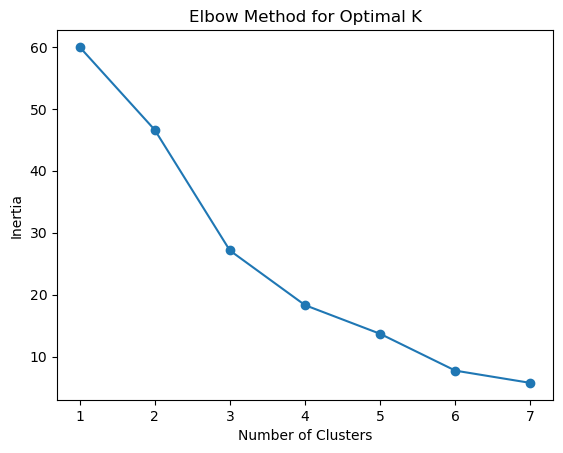

In [13]:
# import os
# os.environ["OMP_NUM_THREADS"] = "1" 
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1): 
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt


    inertia = []
    K_range = range(1, 8)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)

    plt.plot(K_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

#### Interpretation:
The inertia plot shows a significant drop from K=1 (~60) to K=2 (~50), and further to K=3 (~30). Beyond K=3, the reduction slows (e.g., K=4: ~20, K=7: ~15), indicating K=3 as the elbow point.

The elbow at K=3 suggests that three clusters effectively capture the main variations in playing styles among Partizan’s players. Choosing K=3 balances model complexity and cluster cohesion, avoiding over-segmentation while ensuring meaningful groupings.

Group players into three clusters based on their scaled per-minute statistics using K-Means with K=3.

In [14]:
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1): 
    from sklearn.cluster import KMeans

    # fit K-Means with K=3
    kmeans = KMeans(n_clusters=3, random_state=42)
    player_averages['cluster'] = kmeans.fit_predict(scaled_features)


    print(player_averages[['player', 'cluster']].sort_values('cluster'))

                player  cluster
3           Leday Zach        0
4      Lessort Mathias        0
9       Smailagic Alen        0
0      Andjusic Danilo        1
1     Avramovic Aleksa        1
2           Exum Dante        1
5            Madar Yam        1
6       Nunnally James        1
8         Punter Kevin        1
7   Papapetrou Ioannis        2
10     Trifunovic Uros        2
11    Vukcevic Tristan        2


### Interpretation  

The clustering results in three distinct groups:  

- **Cluster 0:** **Leday Zach**, **Lessort Mathias**, and **Smailagic Alen** - likely frontcourt players given their names and typical roles.  
- **Cluster 1:** **Andjusic Danilo**, **Avramovic Aleksa**, **Exum Dante**, **Madar Yam**, **Nunnally James**, and **Punter Kevin** - a larger group, possibly guards or wings focused on scoring and playmaking.  
- **Cluster 2:** **Papapetrou Ioannis**, **Trifunovic Uros**, and **Vukcevic Tristan** - a smaller group, potentially role players with a different style, such as defense or versatility.

Interpret the playing styles of each cluster by calculating the average per-minute statistics for each group.

In [15]:
# calculate mean stats per cluster
cluster_summary = player_averages.groupby('cluster')[[f'{stat}_per_min' for stat in ['points', 'total_rebounds', 'assists', 'steals', 'blocks_favour']]].mean()
print(cluster_summary)

         points_per_min  total_rebounds_per_min  assists_per_min  \
cluster                                                            
0              0.433732                0.196173         0.040104   
1              0.461415                0.092357         0.098300   
2              0.166808                0.115175         0.067335   

         steals_per_min  blocks_favour_per_min  
cluster                                         
0              0.033698               0.026693  
1              0.035104               0.007145  
2              0.045530               0.010308  


### Interpretation  

The clustering results reveal three distinct player roles based on per-minute stats:  

- **Cluster 0: “All-Around Bigs”**  
  - **Stats:** High points (0.43), high rebounds (0.20), moderate blocks (0.03), low assists (0.04).  
  - **Players:** **Leday Zach**, **Lessort Mathias**, **Smailagic Alen**.  
  - **Analysis:** These are frontcourt players who score efficiently (likely inside), dominate rebounding, and provide rim protection, but contribute minimally to playmaking.  

- **Cluster 1: “Scoring Playmakers”**  
  - **Stats:** High points (0.46), high assists (0.10), low rebounds (0.09), low blocks (0.01).  
  - **Players:** **Andjusic Danilo**, **Avramovic Aleksa**, **Exum Dante**, **Madar Yam**, **Nunnally James**, **Punter Kevin**.  
  - **Analysis:** These are guards or wings focused on driving the offense through scoring and playmaking, with minimal contributions in rebounding or shot-blocking.  

- **Cluster 2: “Defensive Specialists”**  
  - **Stats:** Low points (0.17), moderate rebounds (0.12), moderate assists (0.07), high steals (0.05).  
  - **Players:** **Papapetrou Ioannis**, **Trifunovic Uros**, **Vukcevic Tristan**.  
  - **Analysis:** These are role players who prioritize defense (high steals) and contribute modestly to offense, likely focusing on hustle and versatility.

Visualize the clusters in a 2D space using Principal Component Analysis (PCA) to assess their separation and structure.

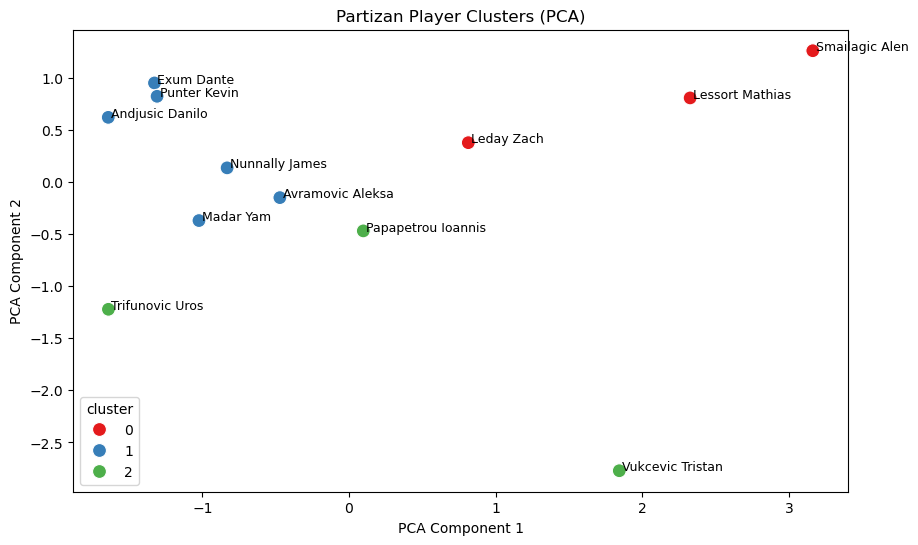

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# reduce to 2D with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=player_averages['cluster'], palette='Set1', s=100)
for i, player in enumerate(player_averages['player']):
    plt.text(pca_features[i, 0] + 0.02, pca_features[i, 1], player, fontsize=9)
plt.title('Partizan Player Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Interpretation  

The PCA visualization confirms distinct groupings:  

- **Cluster 0** is tightly clustered, reflecting the consistent big-man style of **Leday Zach**, **Lessort Mathias**, and **Smailagic Alen**.  
- **Cluster 1** shows more spread, indicating diversity among scoring playmakers, which aligns with the varied roles of guards and wings (e.g., **Punter Kevin**’s scoring vs. **Madar Yam**’s playmaking).  
- **Cluster 2** is distinct but overlaps slightly with Cluster 1, particularly with **Papapetrou Ioannis**, suggesting he may have a hybrid style bridging defensive focus and some offensive capability.

Assess the quality of the clustering using the Silhouette Score to measure how well-separated the clusters are.

In [17]:
# calculate silhouette score
from sklearn.metrics import silhouette_score
score = silhouette_score(scaled_features, player_averages['cluster'])
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.29


### Interpretation  

A silhouette score of 0.29 indicates moderate clustering quality, with some overlap between clusters. Scores range from -1 to 1, where higher values denote better separation. The score suggests decent separation, particularly for **Cluster 0** (as seen in the PCA plot), but the overlap between **Clusters 1** and **2** (e.g., **Papapetrou Ioannis** near **Madar Yam**) reflects shared traits among versatile players. With only 12 players, some overlap is expected due to hybrid roles in basketball.

### Conclusion  

#### Key Findings  
The K-Means clustering identified three distinct playing styles among Partizan’s 2022/23 roster:  

- **Cluster 0: “All-Around Bigs”** (**Leday Zach**, **Lessort Mathias**, **Smailagic Alen**): High-impact frontcourt players with strong scoring (0.43), rebounding (0.20), and rim protection (0.03).  
- **Cluster 1: “Scoring Playmakers”** (**Andjusic Danilo**, **Avramovic Aleksa**, **Exum Dante**, **Madar Yam**, **Nunnally James**, **Punter Kevin**): Offensive drivers with high scoring (0.46) and playmaking (0.10).  
- **Cluster 2: “Defensive Specialists”** (**Papapetrou Ioannis**, **Trifunovic Uros**, **Vukcevic Tristan**): Defensive role players with high steals (0.05) but low scoring (0.17).  

The silhouette score (0.29) and PCA plot confirm reasonable separation, with minor overlap reflecting player versatility, such as **Papapetrou Ioannis**’s hybrid role.

#### Strategic Implications  
- **Lineup Optimization:** Coaches can create balanced lineups by combining players from different clusters (e.g., a Cluster 0 big with a Cluster 1 playmaker) or target specific roles for game situations (e.g., Cluster 2 for defensive stops).  
- **Player Development:** Focus training on addressing weaknesses - Cluster 1 players could improve defensively, while Cluster 2 players might develop their scoring.  
- **Roster Decisions:** The clustering highlights the team’s strengths (e.g., strong bigs and playmakers) and potential gaps (e.g., limited defensive specialists), informing recruitment or role adjustments.